Реализовать синтезирование лиц из LFW с помощью DCGAN


In [1]:
%tensorflow_version 2.x

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from math import sqrt as sq
import tensorflow as tf
import numpy as np
import collections
import os
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (Input, InputLayer, Lambda, Conv2D, 
                                     BatchNormalization, Flatten, Dense, Reshape, 
                                     Conv2DTranspose, Activation, LeakyReLU, Dropout)

In [4]:
# Загрузка LFW Датасета

train_ds, ds_info = tfds.load('lfw', as_supervised=True, with_info=True, split='train')

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompleteOCII8P/lfw-train.tfrecord


Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [5]:
ds_info.features['image']

Image(shape=(250, 250, 3), dtype=tf.uint8)

In [11]:
N_SHOW = 30 # Количество выводимых изображений
INPUT_DIM = 100 # Размерность латентного вектора
NUM_EPOCHS = 10
HALF_BATCH_SIZE = 16  # размер серии генерируемых изображений
BATCH_SIZE = HALF_BATCH_SIZE * 2  # размер серии с учетом реальных изображений
LEARNING_RATE = 0.0004

In [7]:
def plot_images_grid(data, n):
  """
  Принимает на вход объект tensorflow OptionsDataset и выводит матрицу изображений с метками с заданным размером
  """
  samples = data.take(n)
  plt.figure(figsize=(16,12))
  
  # В данном датасете [0] элементом являются метки класса, [1] - само изображение
  for i, sample in enumerate(samples):
      plt.subplot(sq(n)+1,sq(n),i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(sample[1])
      plt.xlabel(sample[0].numpy().decode().replace("_", " "))
  plt.show()

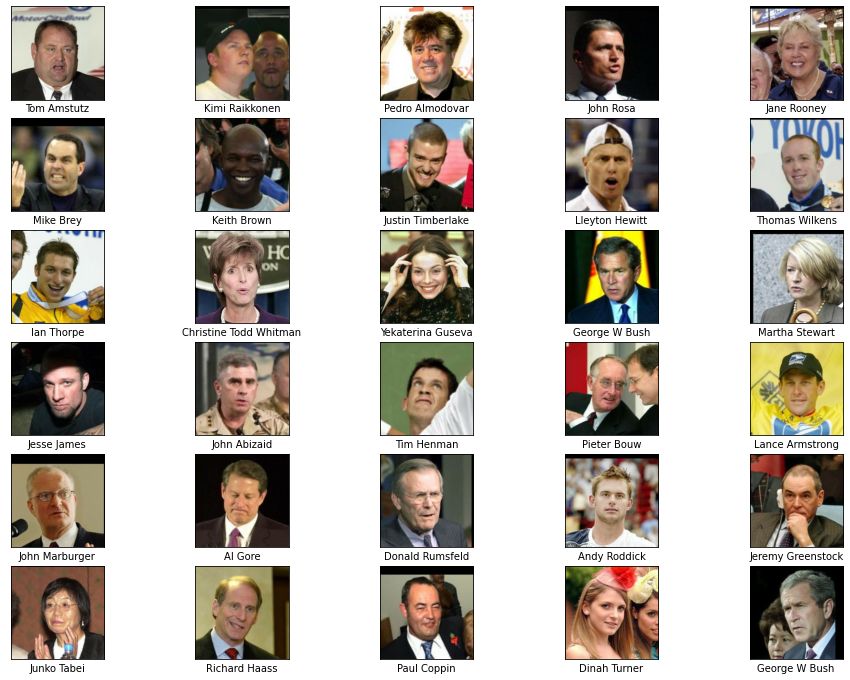

In [8]:
plot_images_grid(train_ds, N_SHOW)

In [9]:
def prepare(label, img):
    img = tf.image.resize(img, [224, 224]) # корректировка размерности входа в модель
    return label, (tf.cast(img, tf.float32) - 127.5) / 127.5  # стандартизация изображения

train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(prepare)

In [10]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256*7*7, activation='relu'),
    tf.keras.layers.Reshape((7, 7, 256)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),  
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),  
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(), 
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(16, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

In [12]:
# Функция выводаа изображений во время обучения
def plot_images(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        new_img = (samples[j, ...] * 127.5) + 127.5
        new_img = (tf.cast(new_img, tf.int16))
        ax.imshow(new_img)
        plt.xticks([]), plt.yticks([])
    plt.show()

In [13]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

[Step  0] D Loss: 0.5740; G Loss: 0.6582


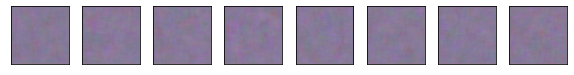

[Step 1000] D Loss: 5.1406; G Loss: 32.1314


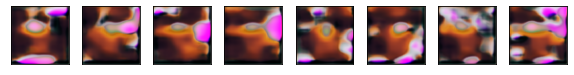

[Step 2000] D Loss: 4.3685; G Loss: 56.0724


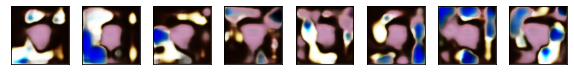

[Step 3000] D Loss: 5.2484; G Loss: 37.9799


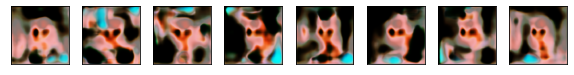

[Step 4000] D Loss: 2.1074; G Loss: 23.5892


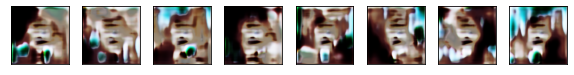

[Step 5000] D Loss: 4.3297; G Loss: 12.9205


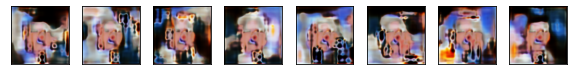

[Step 6000] D Loss: 2.0363; G Loss: 14.8464


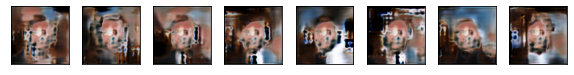

[Step 7000] D Loss: 1.3476; G Loss: 10.2932


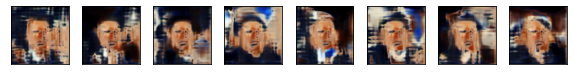

[Step 8000] D Loss: 1.0947; G Loss: 8.5939


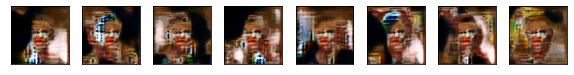

[Step 9000] D Loss: 0.9475; G Loss: 13.6393


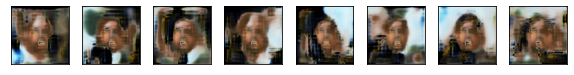

[Step 10000] D Loss: 0.1580; G Loss: 5.9486


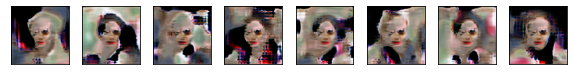

[Step 11000] D Loss: 0.5618; G Loss: 7.4908


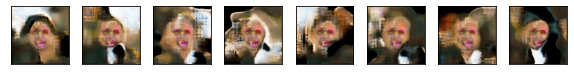

[Step 12000] D Loss: 0.1409; G Loss: 7.0901


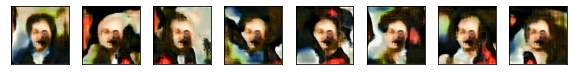

[Step 13000] D Loss: 0.5880; G Loss: 2.9002


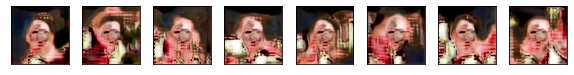

[Step 14000] D Loss: 0.8430; G Loss: 5.3971


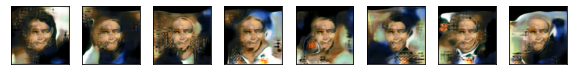

[Step 15000] D Loss: 0.6418; G Loss: 6.5197


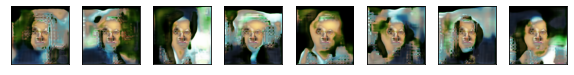

[Step 16000] D Loss: 0.3240; G Loss: 4.6308


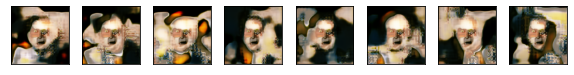

In [14]:
for step, (_, true_images) in enumerate(train_ds):
    
    # Шаг тренеровки дискриминатора
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Шаг тренеровки генератора
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Вывод промежуточных результатов
    
    if step % 1000 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_images(syntetic_images)

In [15]:
# Сохранение весов в  HDF5 файл
generator.save('./models/generator.h5')
discriminator.save('./models/discriminator.h5')

generator.summary()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1266944   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 256)       590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 256)       1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 14, 14, 256)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 256)       0

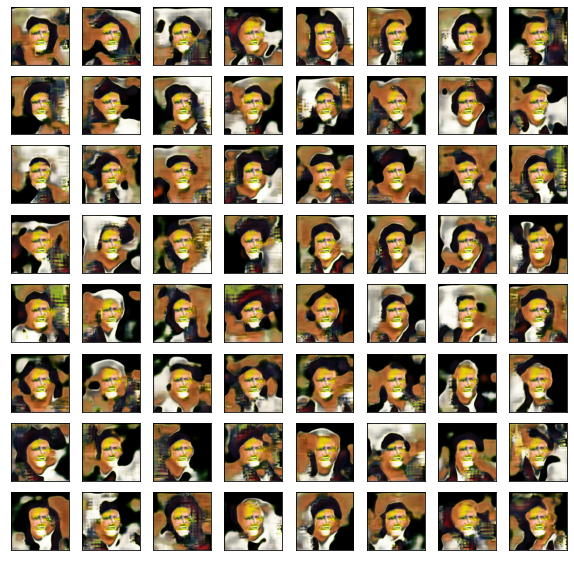

In [16]:
# Тест генератора
noise = np.random.normal(0, 1, (64, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_images(syntetic_images)

Плоховато получилось, но и училась сеть всего ничего.

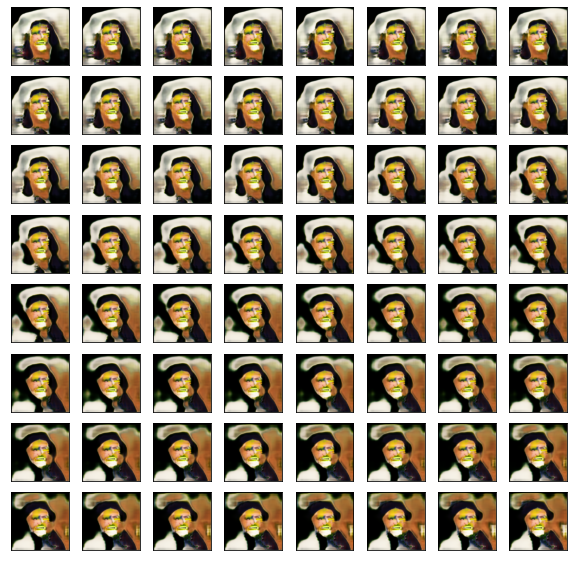

In [17]:
# Интерполяция в латентном пространстве
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 64)
syntetic_images = generator.predict(noise)
plot_images(syntetic_images)